# Template Notebook for using Genetic Algorithms exploring the Prompt Embedding space
Notebook Version: 0.4 (27/03/2024)
* update to new evolutionary library, changes to GA, plotting statistics

## Google Colab Setup

In [ ]:
# Google Colab: Execute this to install packages and setup drive
!pip install "evolutionary[all] @ git+https://git@github.com/malthee/evolutionary-diffusion.git"

In [ ]:
# Mount drive to save results
from google.colab import drive
import evolutionary_imaging.processing as ip
drive.mount("/content/drive")
base_path = "/content/drive/MyDrive/evolutionary/"
ip.RESULTS_FOLDER = base_path + ip.RESULTS_FOLDER

In [ ]:
# Check if GPU is available
import torch
print(torch.cuda.is_available())

## Project Setup

In [10]:
from evolutionary.plotting import plot_fitness_statistics, plot_time_statistics
import evolutionary_imaging.processing as ip
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation
import torch
import os

In [11]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To remove warning of libraries using tokenizers
# Change the results folder for images if you want to 
# ip.RESULTS_FOLDER = 'choose_your_destination'

def save_images_post_evaluation(g, a):
    save_images_from_generation(a.population, g)
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

tensor([ 73,  53, 153,  ...,   0,   0,   0], dtype=torch.uint8)


In [12]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import \
    UniformGaussianMutatorArguments, PooledUniformGaussianMutator, PooledArithmeticCrossover
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange
from evolutionary.evolutionary_selectors import TournamentSelector
from evolutionary.algorithms.ga import GeneticAlgorithm
from evolutionary_imaging.evaluators import AIDetectionImageEvaluator, AestheticsImageEvaluator, CLIPScoreEvaluator, SingleCLIPIQAEvaluator

population_size = 100
num_generations = 20
batch_size = 1
elitism = 1
inference_steps = 3  # Seems like 3 performs better than 4 for aesthetics?
crossover_proportion = 0.5
crossover_rate = 0.9
mutation_rate = 0.5
strict_osga = True

# Define min/max values for the prompt embeddings
embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()

creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=inference_steps)
evaluator = AestheticsImageEvaluator()
crossover = PooledArithmeticCrossover(interpolation_weight=0.5, interpolation_weight_pooled=0.5, 
                                      proportion=crossover_proportion, proportion_pooled=crossover_proportion)
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=2, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=0.4, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments, random population of *reasonable* prompt embeddings
init_args = [PooledPromptEmbedData(embedding_range.random_tensor_in_range(), pooled_embedding_range.random_tensor_in_range()) 
                 for _ in range(population_size)]

# Create and run the genetic algorithm
ga = GeneticAlgorithm(
    population_size=population_size,
    num_generations=num_generations,
    solution_creator=creator,
    evaluator=evaluator,
    mutator=mutator,
    crossover=crossover,
    selector=selector,
    initial_arguments=init_args,
    elitism_count=elitism,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    strict_osga=strict_osga,
    post_evaluation_callback=save_images_post_evaluation,
)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [13]:
best_solution = ga.run()

 55%|█████▌    | 11/20 [38:02:00<31:07:05, 12447.27s/generation]


KeyboardInterrupt: 

7.95925235748291


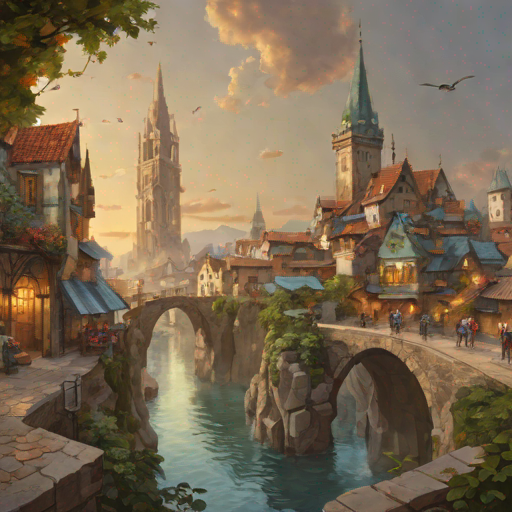

In [5]:
from diffusers.utils import make_image_grid

# Show best solution
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Compare to directly generating it with the prompt (for CLIP-Score, AI-Detection)

In [16]:
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
creator_compare = SDXLPromptEmbeddingImageCreator(batch_size=4, inference_steps=inference_steps)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [ ]:
from diffusers.utils import make_image_grid
args = creator_compare.arguments_from_prompt(prompt)
solution = creator_compare.create_solution(args)
print(evaluator.evaluate(solution.result))
make_image_grid(solution.result.images, 2, 2)

## Visualize the evolution

In [16]:
for gen in range(10):
    create_generation_image_grid(gen, max_images=10)

In [19]:
video_loc = create_animation_from_generations(10)
print(video_loc)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 750) to (1504, 752) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


results/evolution.mp4


## Plot statistics

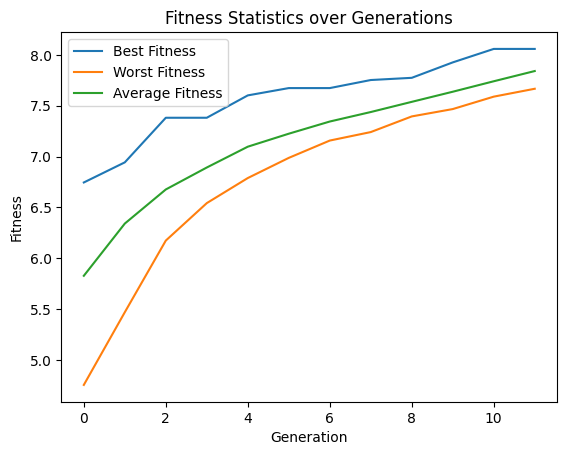

In [21]:
stats = ga.statistics
plot_fitness_statistics(12, stats.best_fitness, stats.worst_fitness, stats.avg_fitness)

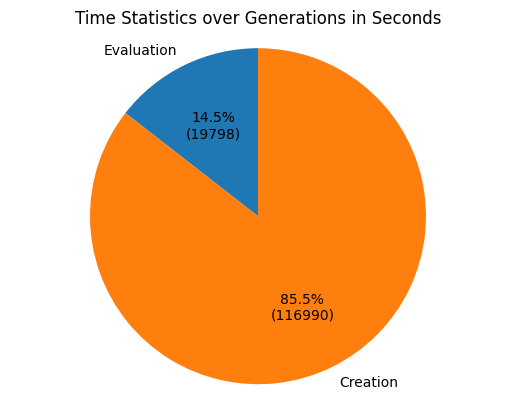

In [22]:
plot_time_statistics(stats.evaluation_time, stats.creation_time)

## Save notebook and components

In [ ]:
!jupyter nbconvert --to html ga_notebook.ipynb

### Save the run to disk

In [22]:
import pickle
import os
from datetime import datetime

os.makedirs("saved_runs", exist_ok=True)
output_file = os.path.join("saved_runs", f"ga_monsteraidetect_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl")
with open(output_file, "wb") as f:
    pickle.dump(ga, f)
print(f"Run saved to {output_file}")

Run saved to saved_runs/ga_monsteraidetect_2024-04-03_12-37-36.pkl


### Load the run from disk 
Notebook and library versions should match with the saved run

In [ ]:
import pickle
import os

with open(os.path.join("saved_runs", "insert_filename"), "rb") as f:
    run = pickle.load(f)

## Fallback functions for when something went wrong

### Access Best Solution from Disk

In [ ]:
import os
import glob
import evolutionary_imaging.processing as ip
from PIL import Image

num_generations = 42  # Set this to the number of generations you ran (if you didn't finish)
generation_dir = os.path.join(ip.RESULTS_FOLDER, f"{num_generations}")
image_files = glob.glob(os.path.join(generation_dir, "*.png"))
image_files.sort(key=ip.fitness_filename_sorting_key, reverse=True)
print(image_files[0])
Image.open(image_files[0])

### ffmpeg is not installed, create GIF instead

In [ ]:
from evolutionary_imaging.processing import create_animation_from_generations_pil
video_loc = create_animation_from_generations_pil(num_generations)
print(video_loc)